In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install tensorflow
!pip install tflite_support
!pip install flatbuffers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 41.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 53.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 55.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
ERROR: pip's dependency resolver does not currently take into accoun

In [3]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix


from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support import metadata as _metadata
import flatbuffers

In [4]:
IMAGES_PATH = "../input/citypersondata/leftImg8bit_trainvaltest/leftImg8bit"
ANNOTS_PATH = "../input/citypersondata/gtBboxCityPersonsWithDangerLevel/gtBboxCityPersonsWithDangerLevel"
BASE_OUTPUT = "output"

TRAIN_FILENAMES = "../input/citypersondata-annot/train.txt"
TEST_FILENAMES = "../input/citypersondata-annot/test.txt"
VAL_FILENAMES = "../input/citypersondata-annot/val.txt"

NUM_CLASSES = 3
OUTPUT_CLASSES = 4 #classes + background

INIT_LR = 1e-4
NUM_EPOCHS = 1
BATCH_SIZE = 16
BUFFER_SIZE = 40

IMG_H = 512#224#512 #384 #360
IMG_W = 512 #224 #512 #512 #480

In [5]:
def getClassFromJson(json_path):
    json_f = open(json_path)
    data = json.load(json_f)
    objects = data["objects"]
    highest_num = 0
    for o in objects:
        danger_level = None
        if "danger_level" in o:
            danger_level = int(o["danger_level"])
        else:
            danger_level = int(o["my_label"])
        
        
        if highest_num < danger_level:
            highest_num = danger_level
        if highest_num == 3:
            break
    return highest_num

In [6]:
trainDataNames = []
trainDataLabels = []
f = open(TRAIN_FILENAMES, "r")
for r in f:
    r = r.split(",") #image path, annotation path
    img_path = r[0]
    annot_path = r[1][:-1] #without \n
    
    class_num = getClassFromJson(annot_path)
    
    trainDataNames.append(img_path)
    trainDataLabels.append(class_num)
    
f.close()

STEPS_PER_EPOCH = len(trainDataNames) // BATCH_SIZE

In [7]:
valDataNames = []
valDataLabels = []
f = open(VAL_FILENAMES, "r")
for r in f:
    r = r.split(",")
    img_path = r[0]
    annot_path = r[1][:-1]

    class_num = getClassFromJson(annot_path)
    
    valDataNames.append(img_path)
    valDataLabels.append(class_num)
    
f.close()

<AxesSubplot:ylabel='count'>

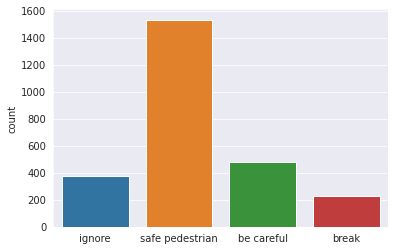

In [8]:
l = []
for i in trainDataLabels:
    if i == 0:
        l.append("ignore")
    elif i == 1:
        l.append("safe pedestrian")
    elif i == 2:
        l.append("be careful")
    elif i == 3:
        l.append("break")
    else:
        print("should not happen")
sns.set_style('darkgrid')
sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])

<AxesSubplot:ylabel='count'>

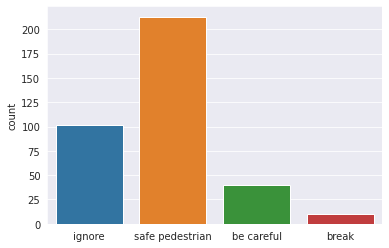

In [9]:
l = []
for i in valDataLabels:
    if i == 0:
        l.append("ignore")
    elif i == 1:
        l.append("safe pedestrian")
    elif i == 2:
        l.append("be careful")
    elif i == 3:
        l.append("break")
    else:
        print("should not happen")
sns.set_style('darkgrid')
sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])

In [10]:
del l

In [11]:
def normalize(input_image, label):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, label

def read_image(image_path, h, w):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    return tf.image.resize(image, [h, w])

def load_image(image_path, label, imageH, imageW):
    input_image = read_image(image_path, imageH, imageW)
    input_image, label = normalize(input_image, label)
    return input_image, label

In [12]:
dataset_train = tf.data.Dataset.from_tensor_slices((trainDataNames, trainDataLabels))
train_images = dataset_train.map(lambda x, y: load_image(x, y, IMG_H, IMG_W), num_parallel_calls=tf.data.AUTOTUNE)


dataset_val = tf.data.Dataset.from_tensor_slices((valDataNames, valDataLabels))
val_images = dataset_val.map(lambda x, y: load_image(x, y, IMG_H, IMG_W), num_parallel_calls=tf.data.AUTOTUNE)

2022-12-06 13:21:39.298426: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        return inputs, labels

In [14]:
train_batches = (
        train_images
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .repeat()
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE))

In [15]:
val_batches = val_images.batch(BATCH_SIZE)

In [16]:
base_model = tf.keras.applications.DenseNet121(input_shape = (IMG_H, IMG_W, 3), include_top = False, weights = "imagenet")

29097984/29084464 [==============================] - 0s 0us/step


In [17]:
base_model.trainable = True

In [18]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(64, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(32, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(4, activation="softmax")                                     
                                ])

In [19]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss_weights=[1.5, 0.40, 1.7, 3.25],
              metrics=['accuracy'])


ep = 5
history = model.fit(train_batches,epochs = ep , validation_data = val_batches, steps_per_epoch=STEPS_PER_EPOCH)

2022-12-06 13:21:44.771921: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

  1/163 [..............................] - ETA: 2:01:29 - loss: 2.5524 - accuracy: 0.1250

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  2/163 [..............................] - ETA: 55:02 - loss: 2.3880 - accuracy: 0.2188  

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  3/163 [..............................] - ETA: 55:15 - loss: 2.4112 - accuracy: 0.2083

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  4/163 [..............................] - ETA: 54:45 - loss: 2.4207 - accuracy: 0.2031

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  5/163 [..............................] - ETA: 53:52 - loss: 2.5979 - accuracy: 0.1750

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  6/163 [>.............................] - ETA: 53:33 - loss: 2.5407 - accuracy: 0.1771

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  7/163 [>.............................] - ETA: 53:11 - loss: 2.5876 - accuracy: 0.1696

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  8/163 [>.............................] - ETA: 52:50 - loss: 2.5350 - accuracy: 0.1953

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  9/163 [>.............................] - ETA: 52:46 - loss: 2.4933 - accuracy: 0.2153

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 10/163 [>.............................] - ETA: 52:20 - loss: 2.4677 - accuracy: 0.2250

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 11/163 [=>............................] - ETA: 51:56 - loss: 2.4319 - accuracy: 0.2273

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 12/163 [=>............................] - ETA: 51:34 - loss: 2.3914 - accuracy: 0.2344

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 13/163 [=>............................] - ETA: 51:05 - loss: 2.3872 - accuracy: 0.2404

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 14/163 [=>............................] - ETA: 50:44 - loss: 2.3914 - accuracy: 0.2500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 15/163 [=>............................] - ETA: 50:21 - loss: 2.4026 - accuracy: 0.2375

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 16/163 [=>............................] - ETA: 49:55 - loss: 2.4047 - accuracy: 0.2344

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 17/163 [==>...........................] - ETA: 49:33 - loss: 2.3718 - accuracy: 0.2426

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 18/163 [==>...........................] - ETA: 49:06 - loss: 2.3835 - accuracy: 0.2361

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 19/163 [==>...........................] - ETA: 48:42 - loss: 2.3836 - accuracy: 0.2303

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 20/163 [==>...........................] - ETA: 48:20 - loss: 2.3912 - accuracy: 0.2250

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 21/163 [==>...........................] - ETA: 47:52 - loss: 2.4031 - accuracy: 0.2232

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 22/163 [===>..........................] - ETA: 47:33 - loss: 2.3915 - accuracy: 0.2273

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 23/163 [===>..........................] - ETA: 47:10 - loss: 2.3777 - accuracy: 0.2310

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 24/163 [===>..........................] - ETA: 46:50 - loss: 2.3632 - accuracy: 0.2344

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 25/163 [===>..........................] - ETA: 46:32 - loss: 2.3724 - accuracy: 0.2375

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 26/163 [===>..........................] - ETA: 46:12 - loss: 2.3665 - accuracy: 0.2380

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 27/163 [===>..........................] - ETA: 45:49 - loss: 2.3561 - accuracy: 0.2431

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 28/163 [====>.........................] - ETA: 45:32 - loss: 2.3552 - accuracy: 0.2433

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 29/163 [====>.........................] - ETA: 45:12 - loss: 2.3575 - accuracy: 0.2457

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 30/163 [====>.........................] - ETA: 44:54 - loss: 2.3484 - accuracy: 0.2521

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 31/163 [====>.........................] - ETA: 44:34 - loss: 2.3463 - accuracy: 0.2560

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 32/163 [====>.........................] - ETA: 44:13 - loss: 2.3499 - accuracy: 0.2578

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 33/163 [=====>........................] - ETA: 43:55 - loss: 2.3437 - accuracy: 0.2595

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 34/163 [=====>........................] - ETA: 43:35 - loss: 2.3508 - accuracy: 0.2574

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 35/163 [=====>........................] - ETA: 43:16 - loss: 2.3589 - accuracy: 0.2554

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 36/163 [=====>........................] - ETA: 42:59 - loss: 2.3429 - accuracy: 0.2639

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 37/163 [=====>........................] - ETA: 42:41 - loss: 2.3366 - accuracy: 0.2652

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 38/163 [=====>........................] - ETA: 42:20 - loss: 2.3328 - accuracy: 0.2632

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 39/163 [======>.......................] - ETA: 42:03 - loss: 2.3317 - accuracy: 0.2628

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 40/163 [======>.......................] - ETA: 41:44 - loss: 2.3188 - accuracy: 0.2672

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 41/163 [======>.......................] - ETA: 41:25 - loss: 2.3160 - accuracy: 0.2698

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 42/163 [======>.......................] - ETA: 41:07 - loss: 2.3151 - accuracy: 0.2693

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 43/163 [======>.......................] - ETA: 40:49 - loss: 2.3079 - accuracy: 0.2689

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 44/163 [=======>......................] - ETA: 40:30 - loss: 2.3039 - accuracy: 0.2685

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 45/163 [=======>......................] - ETA: 40:13 - loss: 2.3138 - accuracy: 0.2639

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 46/163 [=======>......................] - ETA: 39:53 - loss: 2.3104 - accuracy: 0.2622

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 47/163 [=======>......................] - ETA: 39:32 - loss: 2.3155 - accuracy: 0.2646

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 48/163 [=======>......................] - ETA: 39:13 - loss: 2.3063 - accuracy: 0.2669

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 49/163 [========>.....................] - ETA: 38:53 - loss: 2.3011 - accuracy: 0.2679

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 50/163 [========>.....................] - ETA: 38:32 - loss: 2.3014 - accuracy: 0.2637

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 51/163 [========>.....................] - ETA: 38:12 - loss: 2.2995 - accuracy: 0.2647

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 52/163 [========>.....................] - ETA: 37:50 - loss: 2.2942 - accuracy: 0.2668

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 53/163 [========>.....................] - ETA: 37:31 - loss: 2.2922 - accuracy: 0.2665

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 54/163 [========>.....................] - ETA: 37:12 - loss: 2.2907 - accuracy: 0.2685

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 55/163 [=========>....................] - ETA: 36:50 - loss: 2.2952 - accuracy: 0.2670

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 56/163 [=========>....................] - ETA: 36:30 - loss: 2.2840 - accuracy: 0.2690

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 57/163 [=========>....................] - ETA: 36:09 - loss: 2.2859 - accuracy: 0.2686

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 58/163 [=========>....................] - ETA: 35:47 - loss: 2.2825 - accuracy: 0.2672

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 59/163 [=========>....................] - ETA: 35:27 - loss: 2.2880 - accuracy: 0.2638

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 60/163 [==========>...................] - ETA: 35:06 - loss: 2.2838 - accuracy: 0.2667

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 61/163 [==========>...................] - ETA: 34:43 - loss: 2.2786 - accuracy: 0.2684

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 62/163 [==========>...................] - ETA: 34:22 - loss: 2.2801 - accuracy: 0.2681

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 63/163 [==========>...................] - ETA: 34:00 - loss: 2.2780 - accuracy: 0.2679

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 64/163 [==========>...................] - ETA: 33:39 - loss: 2.2733 - accuracy: 0.2715

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 65/163 [==========>...................] - ETA: 33:19 - loss: 2.2666 - accuracy: 0.2740

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 66/163 [===========>..................] - ETA: 32:56 - loss: 2.2657 - accuracy: 0.2737

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 67/163 [===========>..................] - ETA: 32:35 - loss: 2.2588 - accuracy: 0.2771

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/163 [===========>..................] - ETA: 32:14 - loss: 2.2522 - accuracy: 0.2794

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 69/163 [===========>..................] - ETA: 31:53 - loss: 2.2506 - accuracy: 0.2808

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 70/163 [===========>..................] - ETA: 31:32 - loss: 2.2424 - accuracy: 0.2848

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 71/163 [============>.................] - ETA: 31:11 - loss: 2.2361 - accuracy: 0.2879

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 72/163 [============>.................] - ETA: 30:50 - loss: 2.2423 - accuracy: 0.2865

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 73/163 [============>.................] - ETA: 30:29 - loss: 2.2383 - accuracy: 0.2868

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 74/163 [============>.................] - ETA: 30:08 - loss: 2.2310 - accuracy: 0.2897

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 75/163 [============>.................] - ETA: 29:48 - loss: 2.2320 - accuracy: 0.2900

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 76/163 [============>.................] - ETA: 29:28 - loss: 2.2338 - accuracy: 0.2870

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 77/163 [=============>................] - ETA: 29:07 - loss: 2.2352 - accuracy: 0.2873

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 78/163 [=============>................] - ETA: 28:46 - loss: 2.2351 - accuracy: 0.2861

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 79/163 [=============>................] - ETA: 28:25 - loss: 2.2271 - accuracy: 0.2864

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 80/163 [=============>................] - ETA: 28:05 - loss: 2.2289 - accuracy: 0.2852

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 81/163 [=============>................] - ETA: 27:45 - loss: 2.2350 - accuracy: 0.2832

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 82/163 [==============>...............] - ETA: 27:24 - loss: 2.2360 - accuracy: 0.2843

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 83/163 [==============>...............] - ETA: 27:04 - loss: 2.2332 - accuracy: 0.2846

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 84/163 [==============>...............] - ETA: 26:44 - loss: 2.2357 - accuracy: 0.2827

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 85/163 [==============>...............] - ETA: 26:23 - loss: 2.2339 - accuracy: 0.2831

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/163 [==============>...............] - ETA: 26:03 - loss: 2.2319 - accuracy: 0.2849

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 87/163 [===============>..............] - ETA: 25:43 - loss: 2.2299 - accuracy: 0.2830

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 88/163 [===============>..............] - ETA: 25:22 - loss: 2.2282 - accuracy: 0.2841

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 89/163 [===============>..............] - ETA: 25:02 - loss: 2.2247 - accuracy: 0.2844

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 90/163 [===============>..............] - ETA: 24:41 - loss: 2.2216 - accuracy: 0.2868

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 91/163 [===============>..............] - ETA: 24:21 - loss: 2.2199 - accuracy: 0.2871

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 92/163 [===============>..............] - ETA: 24:01 - loss: 2.2108 - accuracy: 0.2908

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 93/163 [================>.............] - ETA: 23:40 - loss: 2.2112 - accuracy: 0.2930

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 94/163 [================>.............] - ETA: 23:20 - loss: 2.2094 - accuracy: 0.2926

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 95/163 [================>.............] - ETA: 23:00 - loss: 2.2131 - accuracy: 0.2914

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 96/163 [================>.............] - ETA: 22:39 - loss: 2.2075 - accuracy: 0.2930

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 97/163 [================>.............] - ETA: 22:19 - loss: 2.2067 - accuracy: 0.2932

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 98/163 [=================>............] - ETA: 22:00 - loss: 2.2015 - accuracy: 0.2934

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 99/163 [=================>............] - ETA: 21:39 - loss: 2.1979 - accuracy: 0.2942

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


100/163 [=================>............] - ETA: 21:19 - loss: 2.2008 - accuracy: 0.2937

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


101/163 [=================>............] - ETA: 20:59 - loss: 2.1999 - accuracy: 0.2933

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


102/163 [=================>............] - ETA: 20:38 - loss: 2.1973 - accuracy: 0.2947

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


103/163 [=================>............] - ETA: 20:18 - loss: 2.1970 - accuracy: 0.2949

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


104/163 [==================>...........] - ETA: 19:57 - loss: 2.1960 - accuracy: 0.2951

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


105/163 [==================>...........] - ETA: 19:36 - loss: 2.1963 - accuracy: 0.2952

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/163 [==================>...........] - ETA: 19:15 - loss: 2.1936 - accuracy: 0.2948

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


107/163 [==================>...........] - ETA: 18:55 - loss: 2.1919 - accuracy: 0.2950

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


108/163 [==================>...........] - ETA: 18:34 - loss: 2.1915 - accuracy: 0.2946

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


109/163 [===================>..........] - ETA: 18:14 - loss: 2.1837 - accuracy: 0.2982

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


110/163 [===================>..........] - ETA: 17:53 - loss: 2.1799 - accuracy: 0.3006

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


111/163 [===================>..........] - ETA: 17:33 - loss: 2.1781 - accuracy: 0.3018

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


112/163 [===================>..........] - ETA: 17:12 - loss: 2.1757 - accuracy: 0.3030

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


113/163 [===================>..........] - ETA: 16:52 - loss: 2.1727 - accuracy: 0.3048

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


114/163 [===================>..........] - ETA: 16:32 - loss: 2.1714 - accuracy: 0.3043

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


115/163 [====================>.........] - ETA: 16:11 - loss: 2.1701 - accuracy: 0.3038

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


116/163 [====================>.........] - ETA: 15:51 - loss: 2.1661 - accuracy: 0.3060

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


117/163 [====================>.........] - ETA: 15:31 - loss: 2.1657 - accuracy: 0.3072

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


118/163 [====================>.........] - ETA: 15:10 - loss: 2.1637 - accuracy: 0.3072

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


119/163 [====================>.........] - ETA: 14:50 - loss: 2.1609 - accuracy: 0.3093

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


120/163 [=====================>........] - ETA: 14:30 - loss: 2.1617 - accuracy: 0.3094

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


121/163 [=====================>........] - ETA: 14:10 - loss: 2.1641 - accuracy: 0.3079

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


122/163 [=====================>........] - ETA: 13:50 - loss: 2.1613 - accuracy: 0.3094

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


123/163 [=====================>........] - ETA: 13:30 - loss: 2.1584 - accuracy: 0.3100

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


124/163 [=====================>........] - ETA: 13:10 - loss: 2.1559 - accuracy: 0.3105

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


125/163 [======================>.......] - ETA: 12:49 - loss: 2.1514 - accuracy: 0.3115

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


126/163 [======================>.......] - ETA: 12:29 - loss: 2.1488 - accuracy: 0.3130

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


127/163 [======================>.......] - ETA: 12:09 - loss: 2.1431 - accuracy: 0.3145

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


128/163 [======================>.......] - ETA: 11:49 - loss: 2.1402 - accuracy: 0.3159

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


129/163 [======================>.......] - ETA: 11:29 - loss: 2.1431 - accuracy: 0.3144

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


130/163 [======================>.......] - ETA: 11:09 - loss: 2.1396 - accuracy: 0.3154

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


131/163 [=======================>......] - ETA: 10:49 - loss: 2.1392 - accuracy: 0.3144

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


132/163 [=======================>......] - ETA: 10:29 - loss: 2.1350 - accuracy: 0.3163

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


133/163 [=======================>......] - ETA: 10:09 - loss: 2.1324 - accuracy: 0.3167

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


134/163 [=======================>......] - ETA: 9:49 - loss: 2.1320 - accuracy: 0.3172 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


135/163 [=======================>......] - ETA: 9:28 - loss: 2.1297 - accuracy: 0.3176

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


136/163 [========================>.....] - ETA: 9:08 - loss: 2.1263 - accuracy: 0.3194

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


137/163 [========================>.....] - ETA: 8:48 - loss: 2.1231 - accuracy: 0.3207

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


138/163 [========================>.....] - ETA: 8:27 - loss: 2.1222 - accuracy: 0.3220

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


139/163 [========================>.....] - ETA: 8:07 - loss: 2.1182 - accuracy: 0.3233

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


140/163 [========================>.....] - ETA: 7:47 - loss: 2.1161 - accuracy: 0.3237

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


141/163 [========================>.....] - ETA: 7:27 - loss: 2.1135 - accuracy: 0.3249

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


142/163 [=========================>....] - ETA: 7:07 - loss: 2.1167 - accuracy: 0.3239

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


143/163 [=========================>....] - ETA: 6:46 - loss: 2.1174 - accuracy: 0.3243

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


144/163 [=========================>....] - ETA: 6:26 - loss: 2.1162 - accuracy: 0.3247

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


145/163 [=========================>....] - ETA: 6:06 - loss: 2.1123 - accuracy: 0.3263

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


146/163 [=========================>....] - ETA: 5:46 - loss: 2.1101 - accuracy: 0.3279

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


147/163 [==========================>...] - ETA: 5:25 - loss: 2.1114 - accuracy: 0.3282

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


148/163 [==========================>...] - ETA: 5:05 - loss: 2.1083 - accuracy: 0.3294

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


149/163 [==========================>...] - ETA: 4:45 - loss: 2.1044 - accuracy: 0.3305

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


150/163 [==========================>...] - ETA: 4:24 - loss: 2.1025 - accuracy: 0.3313

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


151/163 [==========================>...] - ETA: 4:04 - loss: 2.1001 - accuracy: 0.3324

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


152/163 [==========================>...] - ETA: 3:43 - loss: 2.0959 - accuracy: 0.3347

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


153/163 [===========================>..] - ETA: 3:23 - loss: 2.0933 - accuracy: 0.3354

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


154/163 [===========================>..] - ETA: 3:03 - loss: 2.0921 - accuracy: 0.3356

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


155/163 [===========================>..] - ETA: 2:42 - loss: 2.0924 - accuracy: 0.3359

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


156/163 [===========================>..] - ETA: 2:22 - loss: 2.0896 - accuracy: 0.3381

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


157/163 [===========================>..] - ETA: 2:02 - loss: 2.0917 - accuracy: 0.3372

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


158/163 [============================>.] - ETA: 1:41 - loss: 2.0892 - accuracy: 0.3386

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


159/163 [============================>.] - ETA: 1:21 - loss: 2.0877 - accuracy: 0.3392

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


163/163 [==============================] - ETA: 0s - loss: 2.0838 - accuracy: 0.3436 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 3461s 21s/step - loss: 2.0838 - accuracy: 0.3436 - val_loss: 1.5371 - val_accuracy: 0.6082
Epoch 2/5
163/163 [==============================] - ETA: 0s - loss: 1.7344 - accuracy: 0.4981 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 3344s 21s/step - loss: 1.7344 - accuracy: 0.4981 - val_loss: 1.3808 - val_accuracy: 0.6027
Epoch 3/5
163/163 [==============================] - ETA: 0s - loss: 1.6220 - accuracy: 0.5382 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 3285s 20s/step - loss: 1.6220 - accuracy: 0.5382 - val_loss: 1.3426 - val_accuracy: 0.5890
Epoch 4/5
163/163 [==============================] - ETA: 0s - loss: 1.5049 - accuracy: 0.5860 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 3295s 20s/step - loss: 1.5049 - accuracy: 0.5860 - val_loss: 1.3046 - val_accuracy: 0.5863
Epoch 5/5
163/163 [==============================] - ETA: 0s - loss: 1.4500 - accuracy: 0.5914 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 3277s 20s/step - loss: 1.4500 - accuracy: 0.5914 - val_loss: 1.2732 - val_accuracy: 0.5836


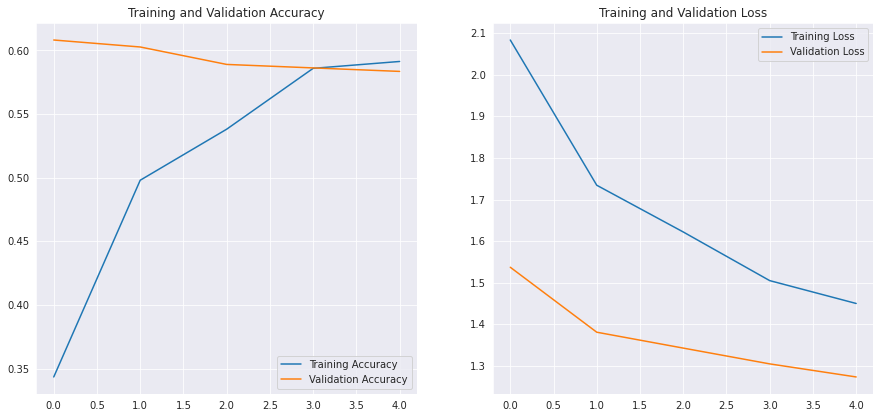

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(ep)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
testDataLabels = []
test_images = []
f = open(TEST_FILENAMES, "r")
for r in f:
    r = r.split(",")
    img_path = r[0]
    annot_path = r[1][:-1]
    img_arr = cv2.imread(img_path)[...,::-1] #convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (IMG_H, IMG_W))

    class_num = getClassFromJson(annot_path)
    
    testDataLabels.append(class_num)
    test_images.append(resized_arr)
    
f.close()

<AxesSubplot:ylabel='count'>

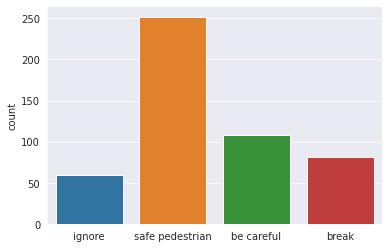

In [22]:
l = []
for i in testDataLabels:
    if i == 0:
        l.append("ignore")
    elif i == 1:
        l.append("safe pedestrian")
    elif i == 2:
        l.append("be careful")
    elif i == 3:
        l.append("break")
    else:
        print("should not happen")
sns.set_style('darkgrid')
sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])

In [23]:
#dataset_test = tf.data.Dataset.from_tensor_slices((testDataNames, testDataLabels))
#test_images = dataset_test.map(lambda x, y: load_image(x, y, IMG_H, IMG_W), num_parallel_calls=tf.data.AUTOTUNE)
test_images = np.array(test_images) / 255
test_images.reshape(-1, IMG_H, IMG_W, 1)

array([[[[0.12156863],
         [0.1372549 ],
         [0.11372549],
         ...,
         [0.27058824],
         [0.19607843],
         [0.2745098 ]],

        [[0.24705882],
         [0.20392157],
         [0.29411765],
         ...,
         [0.61176471],
         [0.50980392],
         [0.66666667]],

        [[0.76862745],
         [0.66666667],
         [0.50588235],
         ...,
         [0.49803922],
         [0.60784314],
         [0.59607843]],

        ...,

        [[0.09803922],
         [0.08627451],
         [0.06666667],
         ...,
         [0.42745098],
         [0.54117647],
         [0.52941176]],

        [[0.16470588],
         [0.23529412],
         [0.21176471],
         ...,
         [0.41568627],
         [0.36078431],
         [0.44705882]],

        [[0.42745098],
         [0.36470588],
         [0.44313725],
         ...,
         [0.09019608],
         [0.08235294],
         [0.07058824]]],


       [[[0.10196078],
         [0.09411765],
         [0.07

In [24]:
predictions = np.argmax(model.predict(test_images, batch_size=BATCH_SIZE), axis=-1)
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(testDataLabels, predictions, target_names = ['Ignore (Class 0)','safe pedestrian (Class 1)', 'Be careful (Class 2)', 'Break (Class 3)']))

                           precision    recall  f1-score   support

         Ignore (Class 0)       1.00      0.05      0.10        59
safe pedestrian (Class 1)       0.59      0.98      0.74       252
     Be careful (Class 2)       0.62      0.09      0.16       108
          Break (Class 3)       0.77      0.62      0.68        81

                 accuracy                           0.62       500
                macro avg       0.75      0.43      0.42       500
             weighted avg       0.68      0.62      0.53       500



In [25]:
confusion = tf.math.confusion_matrix(labels=testDataLabels, predictions=predictions, num_classes=4)
print(confusion)

tf.Tensor(
[[  3  56   0   0]
 [  0 246   3   3]
 [  0  86  10  12]
 [  0  28   3  50]], shape=(4, 4), dtype=int32)


In [26]:
saved_model_dir = 'saved_models'
tf.saved_model.save(model, saved_model_dir)

2022-12-06 18:04:01.470828: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [27]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

2022-12-06 18:05:25.647839: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2022-12-06 18:05:25.647934: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2022-12-06 18:05:25.647944: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2022-12-06 18:05:25.677804: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: saved_models
2022-12-06 18:05:25.843711: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2022-12-06 18:05:25.843807: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: saved_models
2022-12-06 18:05:25.848446: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-06 18:05:26.646800: I tensorflow/cc/saved_mo

In [28]:
with open('densenet_06_12_2pm.tflite', 'wb') as f:
  f.write(tflite_model)

class ModelSpecificInfo(object):
  """Holds information that is specificly tied to an image classifier."""

  def __init__(self, name, version, image_width, image_height, image_min,
               image_max, mean, std, num_classes, author):
    self.name = name
    self.version = version
    self.image_width = image_width
    self.image_height = image_height
    self.image_min = image_min
    self.image_max = image_max
    self.mean = mean
    self.std = std
    self.num_classes = num_classes
    self.author = author

_MODEL_INFO = {
    "densenet_06_12_2pm.tflite":
        ModelSpecificInfo(
            name="MobileNetV2",
            version="v1",
            image_width=512,
            image_height=512,
            image_min=0,
            image_max=255,
            mean=[127.5],
            std=[127.5],
            num_classes=4,
            author="TensorFlow")
}

In [29]:
class MetadataPopulatorForImageClassifier(object):
  """Populates the metadata for an image classifier."""

  def __init__(self, model_file, model_info, label_file_path):
    self.model_file = model_file
    self.model_info = model_info
    self.label_file_path = label_file_path
    self.metadata_buf = None

  def populate(self):
    """Creates metadata and then populates it for an image classifier."""
    self._create_metadata()
    self._populate_metadata()

  def _create_metadata(self):
    """Creates the metadata for an image classifier."""

    # Creates model info.
    model_meta = _metadata_fb.ModelMetadataT()
    model_meta.name = self.model_info.name
    model_meta.description = ("Identify the most prominent object in the "
                              "image from a set of %d categories." %
                              self.model_info.num_classes)
    model_meta.version = self.model_info.version
    model_meta.author = self.model_info.author
    model_meta.license = ("Apache License. Version 2.0 "
                          "http://www.apache.org/licenses/LICENSE-2.0.")

    # Creates input info.
    input_meta = _metadata_fb.TensorMetadataT()
    input_meta.name = "image"
    input_meta.description = (
        "Input image to be classified. The expected image is {0} x {1}, with "
        "three channels (red, blue, and green) per pixel. Each value in the "
        "tensor is a single byte between {2} and {3}.".format(
            self.model_info.image_width, self.model_info.image_height,
            self.model_info.image_min, self.model_info.image_max))
    input_meta.content = _metadata_fb.ContentT()
    input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
    input_meta.content.contentProperties.colorSpace = (
        _metadata_fb.ColorSpaceType.RGB)
    input_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.ImageProperties)
    input_normalization = _metadata_fb.ProcessUnitT()
    input_normalization.optionsType = (
        _metadata_fb.ProcessUnitOptions.NormalizationOptions)
    input_normalization.options = _metadata_fb.NormalizationOptionsT()
    input_normalization.options.mean = self.model_info.mean
    input_normalization.options.std = self.model_info.std
    input_meta.processUnits = [input_normalization]
    input_stats = _metadata_fb.StatsT()
    input_stats.max = [self.model_info.image_max]
    input_stats.min = [self.model_info.image_min]
    input_meta.stats = input_stats

    # Creates output info.
    output_meta = _metadata_fb.TensorMetadataT()
    output_meta.name = "probability"
    output_meta.description = "Probabilities of the %d labels respectively." % self.model_info.num_classes
    output_meta.content = _metadata_fb.ContentT()
    output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
    output_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.FeatureProperties)
    output_stats = _metadata_fb.StatsT()
    output_stats.max = [1.0]
    output_stats.min = [0.0]
    output_meta.stats = output_stats
    label_file = _metadata_fb.AssociatedFileT()
    label_file.name = os.path.basename(self.label_file_path)
    label_file.description = "Labels for objects that the model can recognize."
    label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
    output_meta.associatedFiles = [label_file]

    # Creates subgraph info.
    subgraph = _metadata_fb.SubGraphMetadataT()
    subgraph.inputTensorMetadata = [input_meta]
    subgraph.outputTensorMetadata = [output_meta]
    model_meta.subgraphMetadata = [subgraph]

    b = flatbuffers.Builder(0)
    b.Finish(
        model_meta.Pack(b),
        _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    self.metadata_buf = b.Output()

  def _populate_metadata(self):
    """Populates metadata and label file to the model file."""
    populator = _metadata.MetadataPopulator.with_model_file(self.model_file)
    populator.load_metadata_buffer(self.metadata_buf)
    populator.load_associated_files([self.label_file_path])
    populator.populate()


In [30]:
import flatbuffers
model_file = "densenet_06_12_2pm.tflite"
model_basename = os.path.basename(model_file)

export_model_path = os.path.join(saved_model_dir, model_basename)

# Copies model_file to export_path.
tf.io.gfile.copy(model_file, export_model_path, overwrite=True)

# Generate the metadata objects and put them in the model file
populator = MetadataPopulatorForImageClassifier(
  export_model_path, _MODEL_INFO.get(model_file), "../input/citypersondata-annot/labels.txt")
populator.populate()

In [31]:
# Validate the output model file by reading the metadata and produce
# a json file with the metadata under the export path
displayer = _metadata.MetadataDisplayer.with_model_file(export_model_path)
export_json_file = os.path.join(saved_model_dir, os.path.splitext(model_basename)[0] + ".json")
json_file = displayer.get_metadata_json()
with open(export_json_file, "w") as f:
    f.write(json_file)

In [32]:
print("Finished populating metadata and associated file to the model:")
print(model_file)
print("The metadata json file has been saved to:")
print(export_json_file)
print("The associated file that has been been packed to the model is:")
print(displayer.get_packed_associated_file_list())

Finished populating metadata and associated file to the model:
densenet_06_12_2pm.tflite
The metadata json file has been saved to:
saved_models/densenet_06_12_2pm.json
The associated file that has been been packed to the model is:
['labels.txt']
